In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys

from tqdm.notebook import tqdm
from datetime import datetime


from sklearn.preprocessing import FunctionTransformer, RobustScaler, MinMaxScaler, StandardScaler, LabelBinarizer
from sklearn.preprocessing import normalize, robust_scale, minmax_scale

from sklearn.preprocessing import OneHotEncoder


sys.path.append('/mnt/c/Users/conor/Git_Projects/PHD/')

from Preprocessing_Methods import *

import torch

from scipy.signal import savgol_filter

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


In [4]:
total = pd.read_hdf('/mnt/c/Users/conor/Git_Projects/PHD/Original.hdf', key='Data').round(6)

patient_ids = total.reset_index()['Patient_nu '].unique()

total['1yeardeath'] = ((total.reset_index()['survival (months)']<12) & (total.reset_index()['Alive']==False)).values
total = truncate(total.set_index('1yeardeath', append=True), start=1000, end=1800)

<AxesSubplot:>

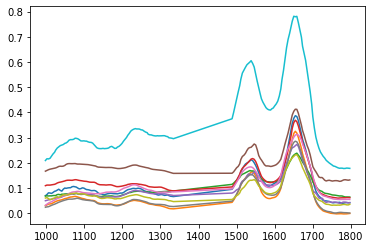

In [5]:
total.sample(10).T.plot(legend=False)

# 1D conv net define

In [6]:
import torch.nn as nn
from torch.utils.data import DataLoader

In [7]:
# Truncate and eliminate paraffin contribution

total_p = pd.DataFrame(FunctionTransformer(normalize, kw_args = {"axis": 1}).fit_transform(total), index=total.index, columns=total.columns)
total_p = total_p.sample(frac=1)

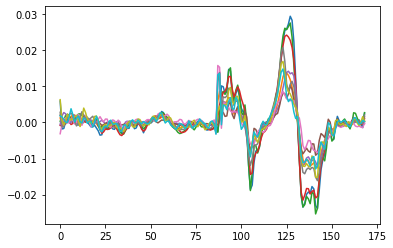

In [8]:
plt.plot(savgol_filter(total_p.sample(10),7,5, deriv=1, axis=1).T);

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [10]:
in_data = np.stack([total_p, savgol_filter(total_p.values, 3,1, deriv=1), savgol_filter(total_p.values, 3,1, deriv=2)],axis=2)

In [11]:
def channel_stack(in_data):

    return np.stack([in_data, savgol_filter(in_data, 3,1, deriv=1), savgol_filter(in_data, 3,1, deriv=2)],axis=2)

In [12]:
train_pats, test_pats = pd.read_pickle('/mnt/c/Users/conor/Git_Projects/PHD/train_indices_20_H.pickle').iloc[0,:]

In [13]:
sel = total_p.sample(frac=1.0)

trn = sel.query(f"Patient_Number in {list(train_pats)}")
tst = sel.query(f"Patient_Number in {list(test_pats)}")

trn_x = channel_stack(trn.values)
tst_x = channel_stack(tst.values)

trn_x = np.expand_dims(trn.values, axis=1)
tst_x = np.expand_dims(tst.values, axis=1)

trn_x = trn.values
tst_x = tst.values

trn_y = OneHotEncoder(sparse=False).fit_transform(trn.reset_index()['1yeardeath'].astype(np.int).values[:,None])
tst_y = OneHotEncoder(sparse=False).fit_transform(tst.reset_index()['1yeardeath'].astype(np.int).values[:,None])

trn_y = trn.reset_index()['1yeardeath'].astype(np.int).values[:,None]
tst_y = tst.reset_index()['1yeardeath'].astype(np.int).values[:,None]


In [14]:
import conv_utils as cu
from convnet import SpecConvNet

import optuna

In [15]:
train_dataset = cu.FTIR_Dataset(trn_x, trn_y)
test_dataset = cu.FTIR_Dataset(tst_x, tst_y)

In [16]:
def conv_objective(trial, epochs=5):

    h_params = {}

    h_params['n_conv_layers'] = trial.suggest_int("n_conv_layers", 2, 5)

    h_params['chan_list'] = [1] # Single channel for first input
    h_params['chan_list'].extend([int(trial.suggest_discrete_uniform(f"num_filter_{i}", 16, 128, 16))
                    for i in range(h_params['n_conv_layers'])])

    h_params['pool_list'] = [int(trial.suggest_discrete_uniform(f"drop_{i}", 3, 9, 2))
                    for i in range(h_params['n_conv_layers'])]

    h_params['fc_neurons'] = int(trial.suggest_discrete_uniform(f"fc_neurons", 16, 512, 16))
    h_params['dropout'] = trial.suggest_float('dropout', 0.25, 0.9)

    # --------------------------------------------------------------------------------------------------

    model = SpecConvNet()
    model.Optuna_build(h_params)

    loss_fn = nn.BCELoss()

    train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True) 

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        
        print(f"Epoch {epoch+1}\n-------------------------------")

        cu.train_loop(train_dataloader, model, loss_fn, optimizer)
        score = cu.test_loop(test_dataloader, model, loss_fn)

        # For pruning (stops trial early if not promising)
        trial.report(score, epoch)
        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return score

In [18]:
study = optuna.create_study(direction="maximize", )

study.optimize(conv_objective, n_trials=10)

[I 2021-10-25 22:38:01,026] A new study created in memory with name: no-name-9a014248-1d02-4157-9796-3dde69cb5ecc
[W 2021-10-25 22:38:01,038] Trial 0 failed because of the following error: AttributeError("module 'conv_utils' has no attribute 'train_loop'")
Traceback (most recent call last):
  File "/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-16-b4aa9228c7c3>", line 35, in conv_objective
    cu.train_loop(train_dataloader, model, loss_fn, optimizer)
AttributeError: module 'conv_utils' has no attribute 'train_loop'


Epoch 1
-------------------------------


AttributeError: module 'conv_utils' has no attribute 'train_loop'

In [69]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_drop_0,params_drop_1,params_drop_2,params_n_conv_layers,params_num_filter_0,params_num_filter_1,params_num_filter_2,state
0,0,0.697917,2021-10-21 16:27:28.731518,2021-10-21 16:38:53.542329,0 days 00:11:24.810811,5.0,3.0,9.0,3,128.0,64.0,32.0,COMPLETE
1,1,0.533613,2021-10-21 16:38:53.543543,2021-10-21 16:47:28.852396,0 days 00:08:35.308853,3.0,9.0,3.0,3,64.0,96.0,96.0,COMPLETE
2,2,0.438710,2021-10-21 16:47:28.853560,2021-10-21 16:55:03.207547,0 days 00:07:34.353987,5.0,3.0,3.0,3,64.0,80.0,96.0,COMPLETE
3,3,0.454545,2021-10-21 16:55:03.208839,2021-10-21 17:02:59.579448,0 days 00:07:56.370609,5.0,7.0,3.0,3,80.0,64.0,112.0,COMPLETE
4,4,0.547619,2021-10-21 17:02:59.580530,2021-10-21 17:06:30.525533,0 days 00:03:30.945003,3.0,7.0,NaN,2,128.0,16.0,NaN,COMPLETE
5,5,0.323671,2021-10-21 17:06:30.526577,2021-10-21 17:16:52.609791,0 days 00:10:22.083214,7.0,9.0,3.0,3,64.0,128.0,80.0,COMPLETE
6,6,0.392857,2021-10-21 17:16:52.610898,2021-10-21 17:17:58.022984,0 days 00:01:05.412086,3.0,9.0,NaN,2,48.0,112.0,NaN,PRUNED
7,7,0.512903,2021-10-21 17:17:58.023627,2021-10-21 17:18:50.725172,0 days 00:00:52.701545,9.0,9.0,NaN,2,32.0,80.0,NaN,PRUNED
8,8,0.600000,2021-10-21 17:18:50.725914,2021-10-21 17:33:07.425770,0 days 00:14:16.699856,3.0,7.0,5.0,3,128.0,96.0,64.0,COMPLETE
9,9,0.456897,2021-10-21 17:33:07.426883,2021-10-21 17:36:32.975637,0 days 00:03:25.548754,5.0,3.0,5.0,3,80.0,16.0,64.0,PRUNED
